In [1]:
!pip install -q Prophet

### Get the data

In [2]:
!wget -nc -q https://lazyprogrammer.me/course_files/airline_passengers.csv

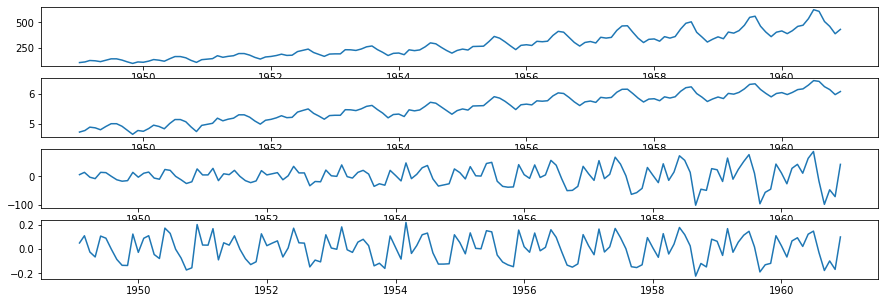

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

fig, ax = plt.subplots(nrows=4, figsize=(15,5));
ax[0].plot(df);
ax[1].plot(df.apply(np.log));
ax[2].plot(df.diff());
ax[3].plot(df.apply(np.log).diff());

In [16]:
# Data format required by Prophet
df.columns = ['y']
df['ds'] = df.index
df.head()

,y,ds
Month,,
1949-01-01,112,1949-01-01
1949-02-01,118,1949-02-01
1949-03-01,132,1949-03-01
1949-04-01,129,1949-04-01
1949-05-01,121,1949-05-01


### Utils

In [71]:
from matplotlib import transforms
import prophet
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

m = dict()         # dict for models
forecast = dict()  # dict for forecasts
df_cv = dict()     # dict for cv dataset

def prophet_fit_forecast(tag,
                         model:prophet.forecaster.Prophet,
                         transform=lambda x:x):
  # Store model
  m[tag] = model
  # Transform data
  df_ = df.copy()
  df_['y'] = transform(df_['y'])
  # Fit
  m[tag].fit(df_)
  # Forecast and store forecast
  future = m[tag].make_future_dataframe(periods=12, freq=df.index.inferred_freq)
  forecast[tag] = m[tag].predict(future)
  # Plot forecast
  fig = m[tag].plot(forecast[tag])
  add_changepoints_to_plot(fig.gca(), m[tag], forecast[tag]);
  plt.show()
  # Plot forecast components
  m[tag].plot_components(forecast[tag])
  plt.show()
  # Cross validation
  df_cv[tag] = cross_validation(m[tag],
    initial='730 days',  # default: 3 x horizon
    #period='182 days',   # default: 1/2 x horizon
    horizon='365 days')
  pm = performance_metrics(df_cv[tag], monthly=True)
  plot_cross_validation_metric(df_cv[tag], metric='smape');
  plt.show()

In [70]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1952-07-01,218.498710,214.282615,222.519991,230,1952-06-03 12:00:00
1,1952-08-01,216.911551,212.432666,221.073962,242,1952-06-03 12:00:00
2,1952-09-01,205.683077,201.787324,209.759101,209,1952-06-03 12:00:00
3,1952-10-01,189.029142,184.794361,193.315972,191,1952-06-03 12:00:00
4,1952-11-01,174.481797,170.277563,178.540742,172,1952-06-03 12:00:00
...,...,...,...,...,...,...
187,1960-08-01,527.261874,502.809299,553.429796,606,1959-12-02 00:00:00
188,1960-09-01,486.085256,460.560774,512.319786,508,1959-12-02 00:00:00
189,1960-10-01,452.406826,426.688136,478.148245,461,1959-12-02 00:00:00
190,1960-11-01,422.596583,399.236790,450.166620,390,1959-12-02 00:00:00


### Compare models

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/hxr9mhd1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/ndrngixh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68353', 'data', 'file=/tmp/tmpf9q3ho8b/hxr9mhd1.json', 'init=/tmp/tmpf9q3ho8b/ndrngixh.json', 'output', 'file=/tmp/tmpf9q3ho8b/prophet_model7c9m20kd/prophet_model-20221010072623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:26:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:26:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


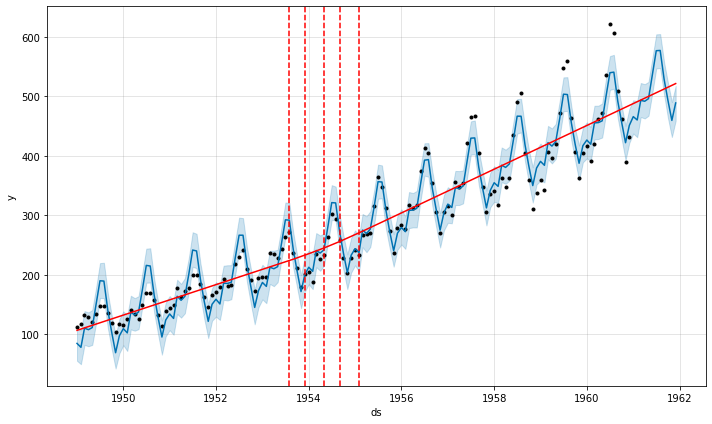

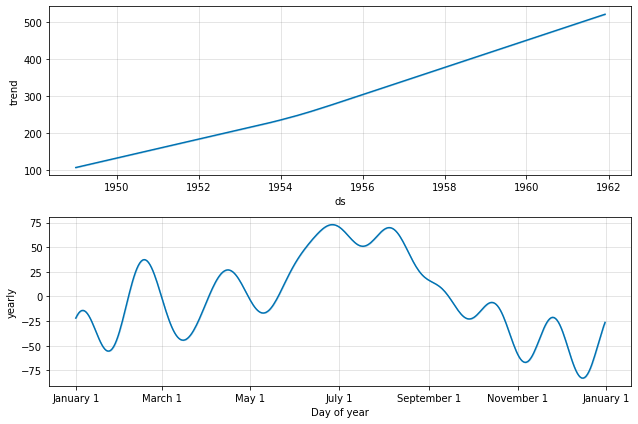

INFO:prophet:Making 18 forecasts with cutoffs between 1951-06-04 12:00:00 and 1959-12-02 00:00:00


  0%|          | 0/18 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/cqaq4n_p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/0baqv6dd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88452', 'data', 'file=/tmp/tmpf9q3ho8b/cqaq4n_p.json', 'init=/tmp/tmpf9q3ho8b/0baqv6dd.json', 'output', 'file=/tmp/tmpf9q3ho8b/prophet_models17e2fqd/prophet_model-20221010072625.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:26:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:26:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/6v6pdusi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/6sqfq85c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:run

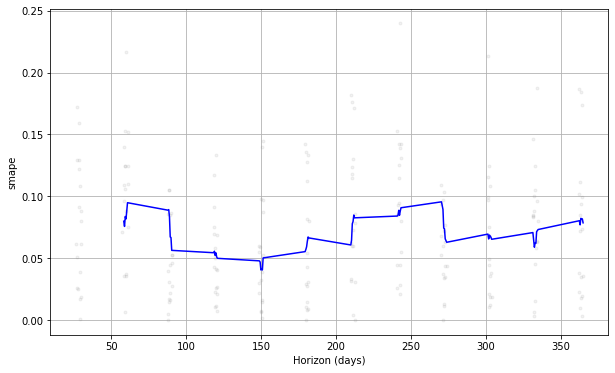

In [72]:
# 1. Basic settings
# Issue: the growing amplitude of the seasonal component is not modelled
prophet_fit_forecast("basic", Prophet())

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/fylnod3n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/le6pa0yb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56314', 'data', 'file=/tmp/tmpf9q3ho8b/fylnod3n.json', 'init=/tmp/tmpf9q3ho8b/le6pa0yb.json', 'output', 'file=/tmp/tmpf9q3ho8b/prophet_modell0fu61ko/prophet_model-20221010072658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:26:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:26:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


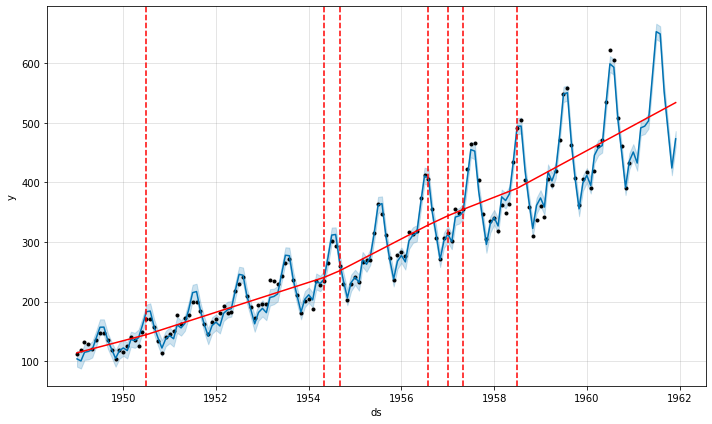

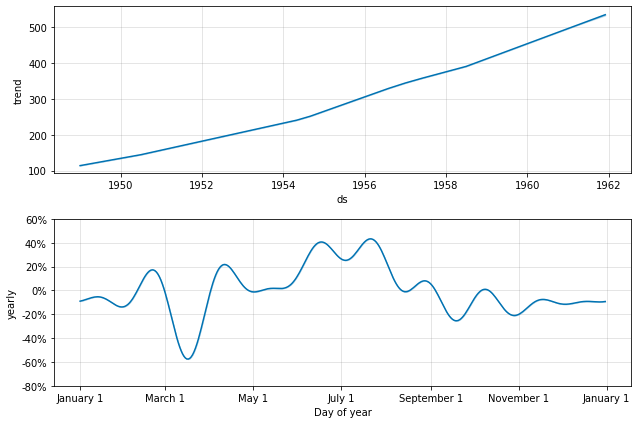

INFO:prophet:Making 18 forecasts with cutoffs between 1951-06-04 12:00:00 and 1959-12-02 00:00:00


  0%|          | 0/18 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/ia4mki_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/9crba1z4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85026', 'data', 'file=/tmp/tmpf9q3ho8b/ia4mki_0.json', 'init=/tmp/tmpf9q3ho8b/9crba1z4.json', 'output', 'file=/tmp/tmpf9q3ho8b/prophet_modelcrw0wq09/prophet_model-20221010072700.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:27:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:27:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/zgn8m0ze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/xznuu4st.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:run

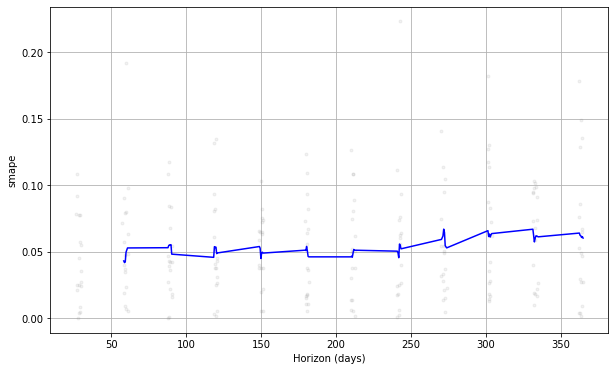

In [73]:
# 2. Multiplicative seasonality to model the growing amplitude
prophet_fit_forecast("multiplicative", Prophet(seasonality_mode='multiplicative'))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/qnv5q7gq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/q8jmmjgu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4475', 'data', 'file=/tmp/tmpf9q3ho8b/qnv5q7gq.json', 'init=/tmp/tmpf9q3ho8b/q8jmmjgu.json', 'output', 'file=/tmp/tmpf9q3ho8b/prophet_modelao4rjnke/prophet_model-20221010073339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:33:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:33:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


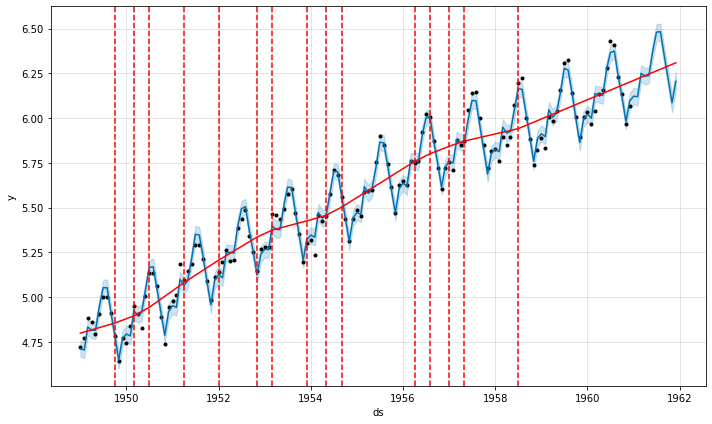

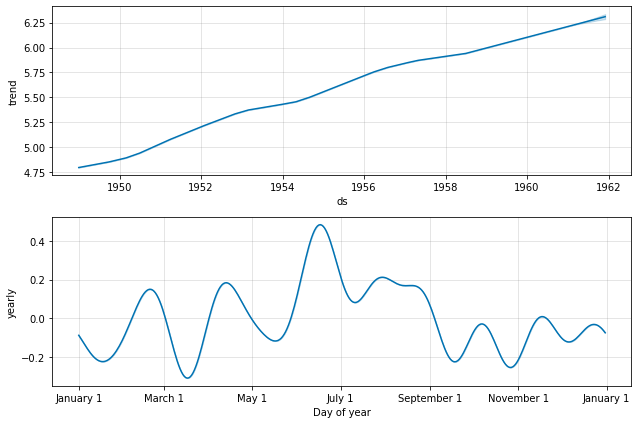

INFO:prophet:Making 18 forecasts with cutoffs between 1951-06-04 12:00:00 and 1959-12-02 00:00:00


  0%|          | 0/18 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/xtxhwtsk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/or7rscft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18304', 'data', 'file=/tmp/tmpf9q3ho8b/xtxhwtsk.json', 'init=/tmp/tmpf9q3ho8b/or7rscft.json', 'output', 'file=/tmp/tmpf9q3ho8b/prophet_modelmrdoil0m/prophet_model-20221010073341.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:33:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:33:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/b6s583en.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/siqc1ddv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:run

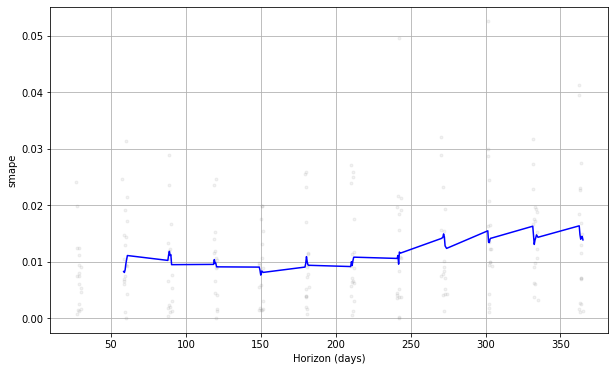

In [74]:
# 3. Log(df) to model the growing amplitude
prophet_fit_forecast("log", Prophet(), transform=np.log)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/ljpu9ajm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/1_gss5om.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78898', 'data', 'file=/tmp/tmpf9q3ho8b/ljpu9ajm.json', 'init=/tmp/tmpf9q3ho8b/1_gss5om.json', 'output', 'file=/tmp/tmpf9q3ho8b/prophet_modelp2dz_g1b/prophet_model-20221010073410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:34:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


boxcox_transform = lambda x: (x**0.15 - 1) / 0.15



07:34:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


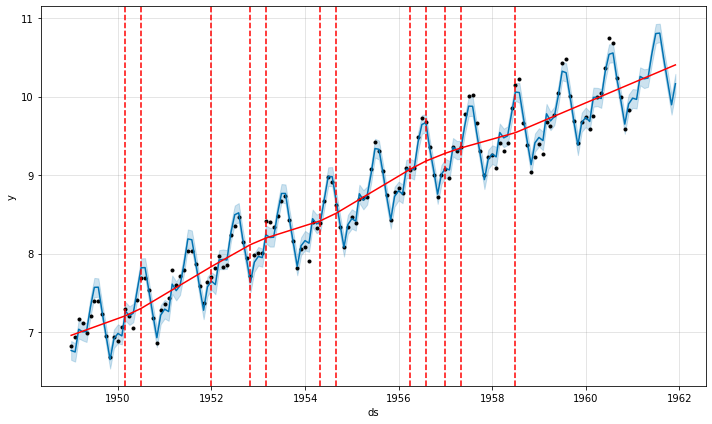

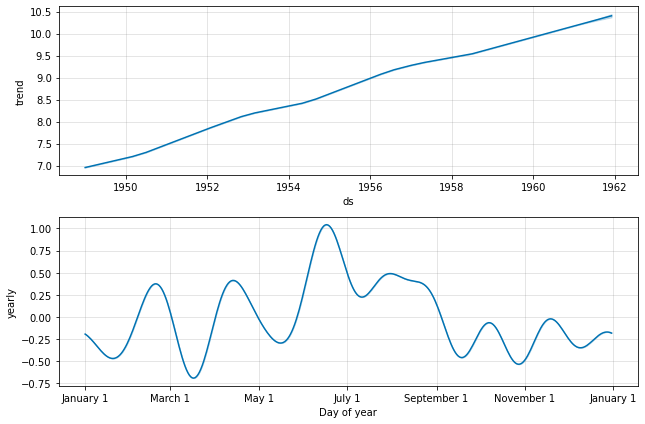

INFO:prophet:Making 18 forecasts with cutoffs between 1951-06-04 12:00:00 and 1959-12-02 00:00:00


  0%|          | 0/18 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/1obcgz2n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/0i24delc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66791', 'data', 'file=/tmp/tmpf9q3ho8b/1obcgz2n.json', 'init=/tmp/tmpf9q3ho8b/0i24delc.json', 'output', 'file=/tmp/tmpf9q3ho8b/prophet_modelyf3szgrh/prophet_model-20221010073412.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:34:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:34:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/rrbewtyf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9q3ho8b/diyqv7_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:run

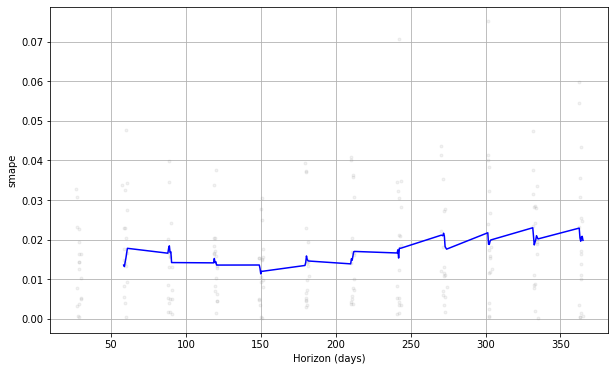

In [75]:
# 4. Use boxcox to determine the best transform
from scipy.stats import boxcox
_ , lam = boxcox(df['y'])
boxcox_transform = (lambda x: (x**lam - 1) / lam) if lam else np.log
print(f'boxcox_transform = {(f"lambda x: (x**{lam:.2f} - 1) / {lam:.2f}") if lam else "np.log"}')
print()
prophet_fit_forecast("boxcox", Prophet(), transform=boxcox_transform)